# Image Generation via Generative Adversarial Networks

hyper parameters

In [53]:
size_minibatch  = 10
dim_latent      = 64
learning_rate = 0.001
number_epoch    = 300
relu_ths=0.2

## import libraries

In [29]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os

## load data

In [30]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2


In [31]:
directory_data  = '/content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2/'
filename_data   = 'assignment_12_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))
real            = data['real_images']

In [32]:
print('size of real data:', real.shape)

size of real data: (4324, 32, 32)


## plot data

In [33]:
def plot_image(title, image):
    
    nRow = 3
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)
   
    for r in range(nRow): 
        for c in range(nCol):
            k = c * 300 + r * nCol * 300
            axes[r, c].imshow(image[k], cmap='gray')

    plt.tight_layout()
    plt.show()

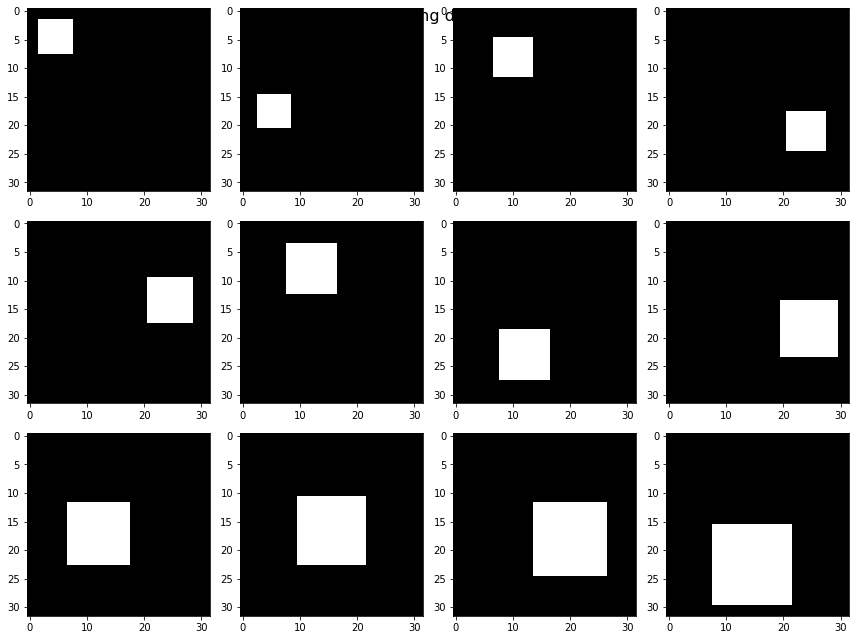

In [34]:
plot_image('training data', real)

## custom data loader for the PyTorch framework

In [35]:
class dataset(Dataset):
    
    def __init__(self, image):
        
        self.image = image
    
    def __getitem__(self, index):
        
        sample  = self.image[index]
        sample  = torch.FloatTensor(sample).unsqueeze(dim=0)

        return (sample)
    
    def __len__(self):

        number_image = len(self.image)

        return (number_image)

## setting device

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
print(device)

cuda


## construct datasets and dataloaders 

In [38]:
dataset_real    = dataset(real)
dataloader_real = torch.utils.data.DataLoader(dataset_real, batch_size=size_minibatch, shuffle=True, drop_last=True)

## neural networks 

In [51]:
class Discriminator(nn.Module): 

	def __init__(self):
        
		super(Discriminator, self).__init__()
		self.decoder = nn.Sequential(
			nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(relu_ths, inplace=True),			
			
			nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(relu_ths, inplace=True),			
			
			nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(relu_ths, inplace=True),			
			
			nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(relu_ths, inplace=True),			
			
			nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(relu_ths, inplace=True),			
		)	
		
		self.classifier = nn.Sequential(
			nn.Linear(128, 64, bias=True),
			nn.LeakyReLU(relu_ths, inplace=True),	

			nn.Linear(64, 32, bias=True),
			nn.LeakyReLU(relu_ths, inplace=True),	

			nn.Linear(32, 16, bias=True),
			nn.LeakyReLU(relu_ths, inplace=True),	

			nn.Linear(16, 8, bias=True),
			nn.LeakyReLU(relu_ths, inplace=True),	

			nn.Linear(8, 1, bias=True),
		) 

		self.network = nn.Sequential(
			self.decoder,
			nn.Flatten(),
			self.classifier,
		)

		self.initialize_weight()

	def forward(self, x):
		y = self.network.forward(x)
		return y

	def initialize_weight(self):
		pass

In [52]:
class Generator(nn.Module): 

	def __init__(self):
		super(Generator, self).__init__()

		self.network = nn.Sequential(
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(64),
			nn.LeakyReLU(relu_ths, inplace=True),
			
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(32),
			nn.LeakyReLU(relu_ths, inplace=True),
			
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(16),
			nn.LeakyReLU(relu_ths, inplace=True),
			
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(8),
			nn.LeakyReLU(relu_ths, inplace=True),
			
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(1),
			
			nn.Sigmoid(),
		) 			

		self.initialize_weight()
		
	def forward(self, x):
		y = self.network.forward(x)
		return y

	def initialize_weight(self):
		pass

## build network

In [41]:
generator       = Generator().to(device)
discriminator   = Discriminator().to(device)

optimizer_generator = torch.optim.SGD(generator.parameters(), lr=learning_rate)
optimizer_discriminator = torch.optim.SGD(discriminator.parameters(), lr=learning_rate)

initialize model parameters : xavier_uniform
initialize model parameters : xavier_uniform


##compute the loss

In [56]:
def compute_loss_discriminator(generator, discriminator, latent, real):
    fake       = compute_prediction(generator, latent)
    prediction_real = compute_prediction(discriminator, real)
    prediction_fake = compute_prediction(discriminator, fake)
    criterion   = nn.BCEWithLogitsLoss() 
    label_real  = torch.ones_like(prediction_real)
    label_fake  = torch.zeros_like(prediction_fake)
    loss_real = criterion(prediction_real, label_real)
    loss_fake = criterion(prediction_fake, label_fake)
    loss_discriminator = (loss_real + loss_fake) / 2.0

    return loss_discriminator

In [57]:
def compute_loss_generator(generator, discriminator, latent):
    fake       = compute_prediction(generator, latent)
    prediction_fake = compute_prediction(discriminator, fake)
    criterion       = nn.BCEWithLogitsLoss()
    label_real      = torch.ones_like(prediction_fake)
    loss_generator  = criterion(prediction_fake, label_real)

    return loss_generator

## compute the prediction

In [44]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the accuracy

In [45]:
def compute_bounding_mask(prediction_binary):
    
    bounding_mask = torch.zeros_like(prediction_binary)
    
    for i in range(prediction_binary.shape[0]):
        prediction = prediction_binary[i]
        
        #(idx_row, idx_col) = torch.nonzero(prediction, as_tuple=True)
        idx_row = torch.nonzero(prediction, as_tuple=True)[0]
        idx_col = torch.nonzero(prediction, as_tuple=True)[1]
        
        if len(idx_row) > 0: 
            idx_row_min = idx_row.min()
            idx_row_max = idx_row.max()
        
            idx_col_min = idx_col.min()
            idx_col_max = idx_col.max()
    
            bounding_mask[i, idx_row_min:idx_row_max+1, idx_col_min:idx_col_max+1] = 1 
        
    return bounding_mask

In [47]:
def compute_accuracy(prediction):

    binary      = (prediction >= 0.5)
    mask        = compute_bounding_mask(binary)
    
    intersection = (binary & mask).float().sum((1, 2))
    union        = (binary | mask).float().sum((1, 2))

    eps         = 1e-8
    correct     = (intersection + eps) / (union + eps)
    accuracy    = correct.mean() * 100.0
    accuracy    = accuracy.cpu() 
    
    return accuracy

## train

In [48]:
def train(generator, discriminator, dataloader):
    
    for index_batch, (real) in enumerate(dataloader):
        real        = real.to(device)
        size_batch  = len(real)
        latent      = torch.randn(size_batch, dim_latent, device=device)
        latent      = torch.reshape(latent, [size_batch, dim_latent, 1, 1])

        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()

        optimizer_generator.zero_grad()
        loss_generator = compute_loss_generator(generator, discriminator, latent)
        loss_generator.backward()
        optimizer_generator.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()

        optimizer_discriminator.zero_grad()
        #
        loss_discriminator = compute_loss_discriminator(generator, discriminator, latent, real)
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        data_fake   = compute_prediction(generator, latent)
        accuracy    = compute_accuracy(data_fake)
        

## test

In [49]:
def test(generator, latent):
    
    generator.eval()
    
    prediction  = generator(latent)
    prediction  = prediction.squeeze(axis=1)
    accuracy    = compute_accuracy(prediction)
    
    return accuracy

## training epoch

In [23]:

accuracy_epoch  = np.zeros(number_epoch)

num_latent_test = 100
latent_test = torch.randn(num_latent_test, dim_latent, device=device)
latent_test = torch.reshape(latent_test, [num_latent_test, dim_latent, 1, 1])

for i in tqdm(range(number_epoch)):
    train(generator, discriminator, dataloader_real)
    accuracy = test(generator, latent_test)
    accuracy_epoch[i] = accuracy

100%|██████████| 300/300 [43:15<00:00,  8.65s/it]


---

# functions for presenting the results

---

In [24]:
def function_result_01():

    num_latent_visualize = 16

    latent_visualize = torch.randn(num_latent_visualize, dim_latent, device=device)
    latent_visualize = torch.reshape(latent_visualize, [num_latent_visualize, dim_latent, 1, 1]) 

    prediction = compute_prediction(generator, latent_visualize)
    prediction = prediction.squeeze(axis=1)
    prediction_binary = (prediction >= 0.5)
    bounding_mask = compute_bounding_mask(prediction_binary)
        
    fake = prediction.detach().cpu()
    mask = bounding_mask.detach().cpu()

    nRow = 4
    nCol = 4 
    size = 3 
    
    title = 'fake image'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(fake[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()
    
    title = 'bounding mask'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(mask[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)
                        
    plt.tight_layout()
    plt.show()

In [25]:
def function_result_02():

    title           = 'accuracy'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)
    
    plt.plot(accuracy_epoch)
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [26]:
def function_result_03():

    print('final accuracy = %9.8f' % (accuracy_epoch[-1]))

---

## results

---


################################################################################
#
# RESULT # 01
#
################################################################################



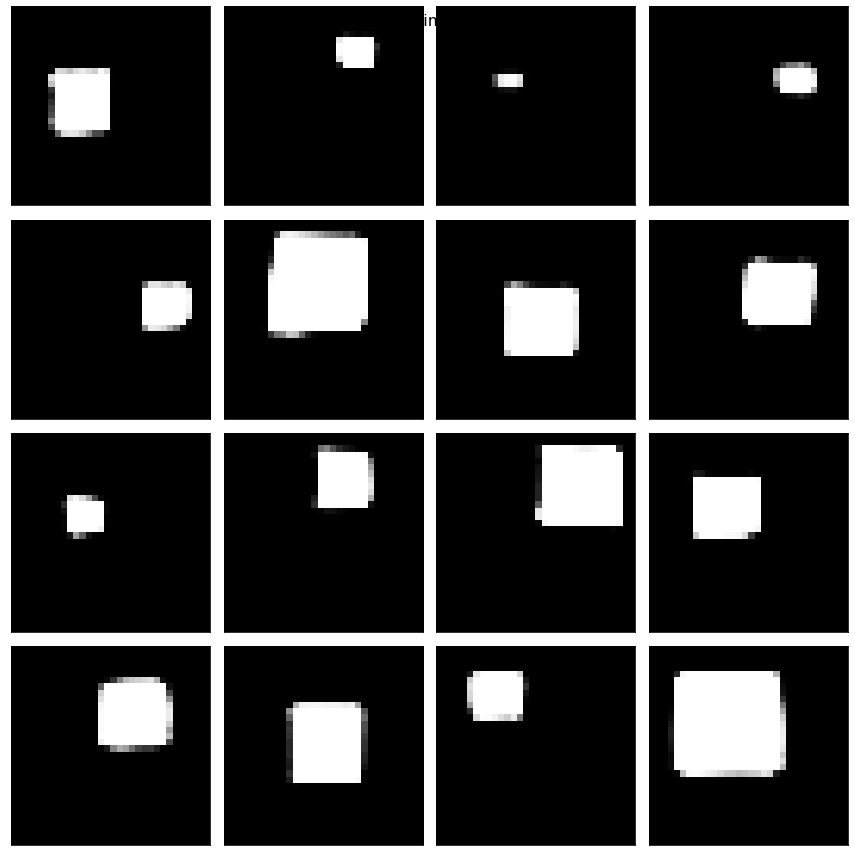

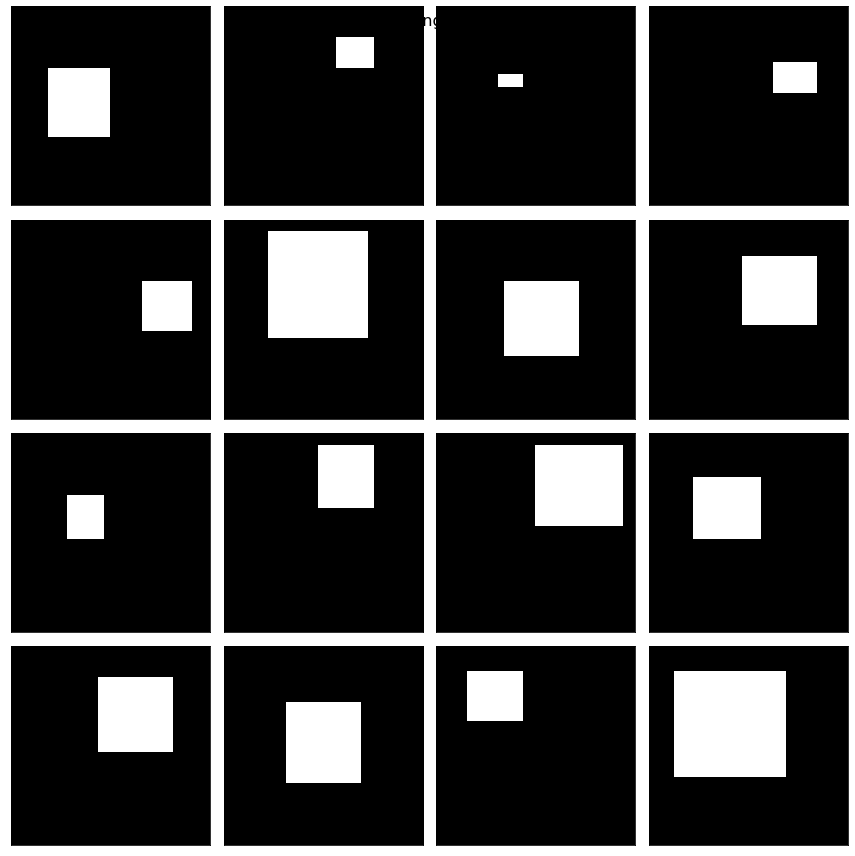


################################################################################
#
# RESULT # 02
#
################################################################################



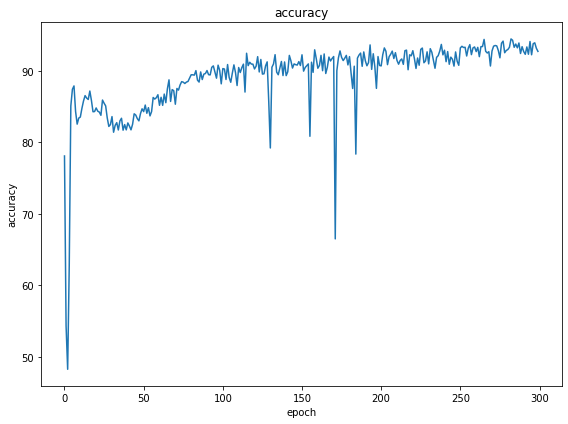


################################################################################
#
# RESULT # 03
#
################################################################################

final accuracy = 92.72616577


In [27]:
number_result = 3

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)

In [58]:
!apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [1,073 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:1

In [59]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain

In [60]:
!jupyter nbconvert --to PDF '/content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2/assignment_12.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2/assignment_12.ipynb to PDF
[NbConvertApp] Support files will be in assignment_12_files/
[NbConvertApp] Making directory ./assignment_12_files
[NbConvertApp] Writing 50606 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 59438 bytes to /content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2/assignment_12.pdf
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2/assignment_12.ipynb.ipynb to PDF
[NbConvertApp] Support files will be in assignment_12.ipynb_files/
[NbConvertApp] Making directo